In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC, QSVC
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.model_selection import train_test_split, cross_val_score
from qiskit_algorithms.utils import algorithm_globals
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

In [2]:
# %%
loan_dataset = pd.read_csv('Loan_data.csv')
print(loan_dataset)


     Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1.0      0.0    0.000000        1.0       1.000000         0.082523   
1       0.0      1.0    0.000000        1.0       0.000000         0.028114   
2       1.0      1.0    0.500000        1.0       0.000000         0.097093   
3       1.0      1.0    0.000000        1.0       0.000000         0.095869   
4       1.0      1.0    0.000000        1.0       0.000000         0.032764   
..      ...      ...         ...        ...            ...              ...   
539     1.0      1.0    0.515232        0.0       0.000000         0.049508   
540     1.0      1.0    0.000000        0.0       0.000000         0.033323   
541     0.0      0.0    0.000000        1.0       0.000000         0.028889   
542     0.0      0.0    0.000000        1.0       0.000000         0.097166   
543     0.0      0.0    0.000000        1.0       0.433521         0.033229   

     CoapplicantIncome  LoanAmount  Loan_Amount_Ter

In [3]:

# %%
features = loan_dataset.drop(columns='Loan_Status', axis=1).values
labels = loan_dataset['Loan_Status'].values

In [4]:
# %%
features_train,  features_test, label_train,label_test = train_test_split(features, labels, test_size=0.2, random_state=33)


In [5]:
# %%
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='linear')
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
# feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


In [6]:
# Function to evaluate in batches
def evaluate_in_batches(quantum_kernel, features_train, features_test, batch_size):
    num_train = len(features_train)
    num_test = len(features_test)
    kernel_matrix_train = np.zeros((num_train, num_train))
    kernel_matrix_test = np.zeros((num_test, num_train))

    # Process training kernel in batches
    for i in range(0, num_train, batch_size):
        end_i = min(i + batch_size, num_train)
        kernel_matrix_train[i:end_i, :] = quantum_kernel.evaluate(x_vec=features_train[i:end_i], y_vec=features_train)

    # Process testing kernel in batches
    for i in range(0, num_test, batch_size):
        end_i = min(i + batch_size, num_test)
        kernel_matrix_test[i:end_i, :] = quantum_kernel.evaluate(x_vec=features_test[i:end_i], y_vec=features_train)
    
    return kernel_matrix_train, kernel_matrix_test


In [7]:
# Evaluate kernel matrices in batches
batch_size = 25  # Adjust batch size as needed
kernel_matrix_train, kernel_matrix_test = evaluate_in_batches(quantum_kernel, features_train, features_test, batch_size)


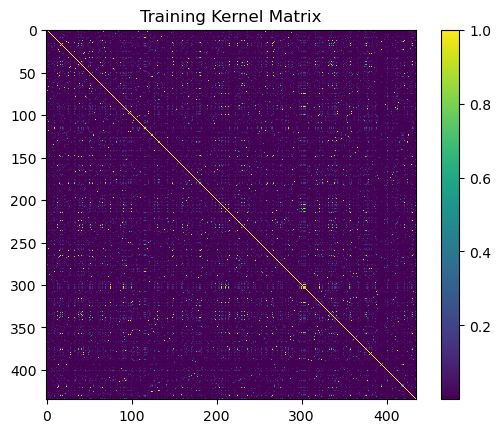

In [8]:
# Visualize the kernel matrix
plt.imshow(kernel_matrix_train, interpolation='nearest')
plt.title("Training Kernel Matrix")
plt.colorbar()
plt.show()

In [9]:
svc = SVC(kernel='precomputed')
svc.fit(kernel_matrix_train, label_train)

SVC(kernel='precomputed')

In [10]:
score = svc.score(kernel_matrix_test, label_test)
print(f"Classification accuracy: {score * 100}%")

Classification accuracy: 78.89908256880734%


In [15]:
# Cross-validation to ensure robustness
cross_val_scores_qk = cross_val_score(svc, kernel_matrix_train, label_train, cv=5)
print(f"Quantum Kernel SVM Cross-Validation Scores: {cross_val_scores_qk}")
print(f"Quantum Kernel SVM Mean CV Accuracy: {np.mean(cross_val_scores_qk) * 100:.2f}%")


Quantum Kernel SVM Cross-Validation Scores: [0.74712644 0.75862069 0.70114943 0.77011494 0.71264368]
Quantum Kernel SVM Mean CV Accuracy: 73.79%


In [12]:
# Additional: Compare with a classical SVM
svc_classical = SVC()
svc_classical.fit(features_train, label_train)
score_classical = svc_classical.score(features_test, label_test)
print(f"Classical SVM Classification accuracy: {score_classical * 100:.2f}%")


Classical SVM Classification accuracy: 67.89%


In [16]:
# Cross-validation for Classical SVM
cross_val_scores_classical = cross_val_score(svc_classical, features_train, label_train, cv=5)
print(f"Classical SVM Cross-Validation Scores: {cross_val_scores_classical}")
print(f"Classical SVM Mean CV Accuracy: {np.mean(cross_val_scores_classical) * 100:.2f}%")

Classical SVM Cross-Validation Scores: [0.67816092 0.70114943 0.68965517 0.74712644 0.68965517]
Classical SVM Mean CV Accuracy: 70.11%
